In [ ]:
import pandas as pd
import requests
import io
# Download the dataset from the provided URL
url_train = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/train_no_labels.json.gz'
url_valid = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/valid.json.gz'

response_train = requests.get(url_train)
response_valid = requests.get(url_valid)

# Read the JSON data into pandas DataFrames
train_data = pd.read_json(io.BytesIO(response_train.content), compression='gzip')
valid_data = pd.read_json(io.BytesIO(response_valid.content), compression='gzip')

In [ ]:
import numpy as np

train_data['image_array'] = train_data['image'].apply(lambda x: np.array(x, dtype=np.uint8))

In [ ]:
valid_data['image_array'] = valid_data['image'].apply(lambda x: np.array(x, dtype=np.uint8))

In [ ]:
from PIL import Image

def resize_image(img_array, size=(128, 128)):
    pil_img = Image.fromarray(img_array)
    return np.array(pil_img.resize(size))

train_data['image_resized'] = train_data['image_array'].apply(lambda x: resize_image(x))

In [ ]:
valid_data['image_resized'] = valid_data['image_array'].apply(lambda x: resize_image(x))

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
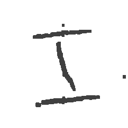

In [ ]:
train_data.image_resized[0]

In [ ]:
train_data['image_normalized'] = train_data['image_resized'].apply(lambda x: x / 255.0)

In [ ]:
valid_data['image_normalized'] = valid_data['image_resized'].apply(lambda x: x / 255.0)

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet18

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
])

model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove camada final (classificação)
model.eval()

def get_embedding(image_np):
    if image_np.ndim == 2:  # escala de cinza
        image_np = np.stack([image_np] * 3, axis=-1)

    img_tensor = transform(image_np).unsqueeze(0)  # shape: [1, 3, 224, 224]
    with torch.no_grad():
        embedding = model(img_tensor).squeeze().numpy()
    return embedding


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [6]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
train_data['embedding'] = train_data['image_array'].progress_apply(get_embedding)
X_embedded = np.stack(train_data['embedding'].values)

100%|██████████| 2406/2406 [02:26<00:00, 16.40it/s]


In [ ]:
valid_data['embedding'] = valid_data['image_array'].progress_apply(get_embedding)

100%|██████████| 425/425 [00:25<00:00, 16.95it/s]


In [ ]:
train_data.to_pickle('train_data_embeddings.pkl')

In [ ]:
valid_data.to_pickle('valid_data_embeddings.pkl')

## UMAP - for a visual analysis

In [15]:
! pip -q install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.8/349.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [5]:
train_data = pd.read_pickle('/content/drive/MyDrive/EliasProj2/train_data_embeddings.pkl')
valid_data = pd.read_pickle('/content/drive/MyDrive/EliasProj2/valid_data_embeddings.pkl')

In [6]:
def parse_embedding(s):
    return np.fromstring(s.strip("[]"), sep=' ')

In [7]:
import umap.umap_ as umap

In [8]:
# X_embedded:  matriz de embeddings (shape [n amostras, 512])
X_embedded = np.stack(train_data['embedding'].values)

reducer = umap.UMAP(n_components=2, random_state=42)
X_2d = reducer.fit_transform(X_embedded)

# Adiciona ao DataFrame para visualização
train_data['umap_1'] = X_2d[:, 0]
train_data['umap_2'] = X_2d[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


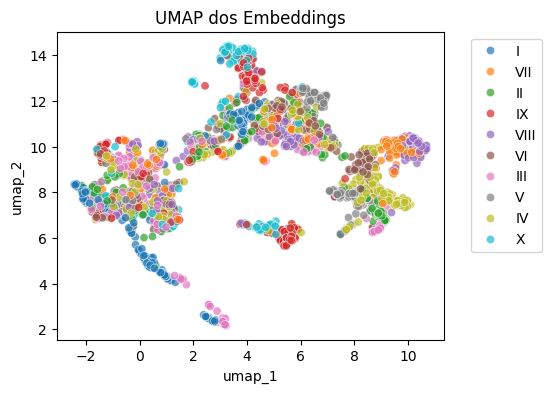

In [9]:
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=train_data,
    x='umap_1',
    y='umap_2',
    hue='label',
    palette='tab10',
    alpha=0.7
)
plt.title('UMAP dos Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [7]:
X = train_data.drop(columns='label')
y = train_data['label'].values

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

svc = SVC(gamma='auto', probability=True, random_state=42)
lr_model = LogisticRegression(random_state=42)
mlp = MLPClassifier(random_state=42)

In [10]:
from sklearn.ensemble import StackingClassifier

stacked = StackingClassifier(
    estimators=[
        ('svc', svc),
        ('lr', lr_model),
        ('mlp', mlp)
    ],
    final_estimator=LogisticRegression(max_iter=200),
    passthrough=True,
    cv=5
)

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, make_scorer
import numpy as np

# MCC como scorer
mcc_scorer = make_scorer(matthews_corrcoef)

scores = cross_val_score(
    estimator=stacked,
    X=np.stack(X_train.embedding),
    y=y_train,
    cv=5,
    scoring=mcc_scorer
)

In [15]:
print(scores)

[0.74334607 0.71488419 0.66791573 0.70858511 0.73930898]


In [16]:
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(
    estimator=stacked,
    X=np.stack(X.embedding),
    y=y,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)

In [18]:
from cleanlab.filter import find_label_issues


y = le.transform(y)

issues = find_label_issues(
    labels=y,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # ordena os mais suspeitos no topo
)

In [27]:
issues

array([ 313, 2155,  411, 2253, 1179,  345,  602,  137, 1458, 2056,  286,
       1545,  282,  807,  761,  154, 2188,   91, 1064,   77, 1895, 1988,
        889,  869, 1339, 1152, 1570, 1246,  587, 2163,  927,  463, 1882,
          6, 2335,  667, 1940, 2034,  227, 1365,  441, 1181, 1838,  715,
       1949,  327,  199, 1779,  166,  378, 1350,  388, 1666, 1223,  176,
        206,  162,  948, 1852,  390, 1445, 1210,  284, 1119, 1914, 1725,
       1871, 1760, 2055,  281,  534,  139,  429,  899,  537, 1941,  543,
       2040, 1186,  503, 1519, 1851, 1358,  146, 1787, 2377,  478, 1446,
       1175,  874, 1146,  929,  666,  333, 2021,  539,   81,  770, 1995,
       1351, 1798,  354,    4, 2371,  704, 1262,   60,  210,  991,  981,
       1984, 1599, 2238, 1729, 1163,  144, 1114, 1467,  905, 2209, 2147,
        676, 1676, 2293, 1981,   78, 2298, 2303,  760,   50,   27, 2318,
        882, 2362,  412, 2255, 1319,  771, 2158,  783,  431,  718, 1662,
        136,  118, 1400, 1854,  939, 1886, 2208, 14

In [24]:
(len(issues) / len(y) )* 100

16.167913549459684

In [25]:
label_info = pd.DataFrame({'label': y})
label_info['noisy'] = False
label_info.loc[issues, 'noisy'] = True


In [26]:
label_info

,label,noisy
0,0,False
1,7,False
2,1,False
3,4,False
4,1,True
...,...,...
2401,4,False
2402,0,False
2403,5,False
2404,8,False


In [28]:
label_info.to_parquet('label_info.parquet')